In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Step 1: Load the Data
simout_data = pd.read_excel('../steady_state_data/SIMOUT.xlsx')
xmv_data = pd.read_excel('../steady_state_data/XMV.xlsx')
tout_data = pd.read_excel('../steady_state_data/TOUT.xlsx')

# Step 2: Select Specified Columns
# Columns from SIMOUT: A to G (0 to 6), K to V (10 to 21), AP to AS (40 to 43)
simout_features = simout_data.iloc[:, list(range(0, 7)) + list(range(10, 22)) + list(range(41, 44))]

# Columns from XMV: G to I (6 to 8)
xmv_features = xmv_data.iloc[:, 6:9]

# Target variable (e.g., concentration of product G )
y = simout_data.iloc[:, 39]  # 39 because indexing starts at 0

# Step 3: Combine Selected Features from SIMOUT and XMV
X = pd.concat([simout_features, xmv_features], axis=1)

# Convert all column names to strings to avoid type issues
X.columns = X.columns.astype(str)

# Step 4: Data Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Print the shapes of the prepared data for verification
print("Shape of feature data (X):", X.shape)
print("Shape of target data (y):", y.shape)


Shape of feature data (X): (27001, 25)
Shape of target data (y): (27001,)


In [61]:
# Step 2: Remove Outliers Using the IQR Method

# Calculate the IQR for each numerical feature
Q1 = pd.DataFrame(X_scaled).quantile(0.25)
Q3 = pd.DataFrame(X_scaled).quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the rows where any feature value is outside the IQR bounds
outliers = ((pd.DataFrame(X_scaled) < lower_bound) | (pd.DataFrame(X_scaled) > upper_bound)).any(axis=1)

# Remove the outliers from X and y
X_cleaned = X_scaled[~outliers]
y_cleaned = y[~outliers]

# Print the shapes of the cleaned data for verification
print("Shape of cleaned feature data (X_cleaned):", X_cleaned.shape)
print("Shape of cleaned target data (y_cleaned):", y_cleaned.shape)


Shape of cleaned feature data (X_cleaned): (23475, 25)
Shape of cleaned target data (y_cleaned): (23475,)


In [62]:
###Feature engineering and analysis
#Exploratory data analysis


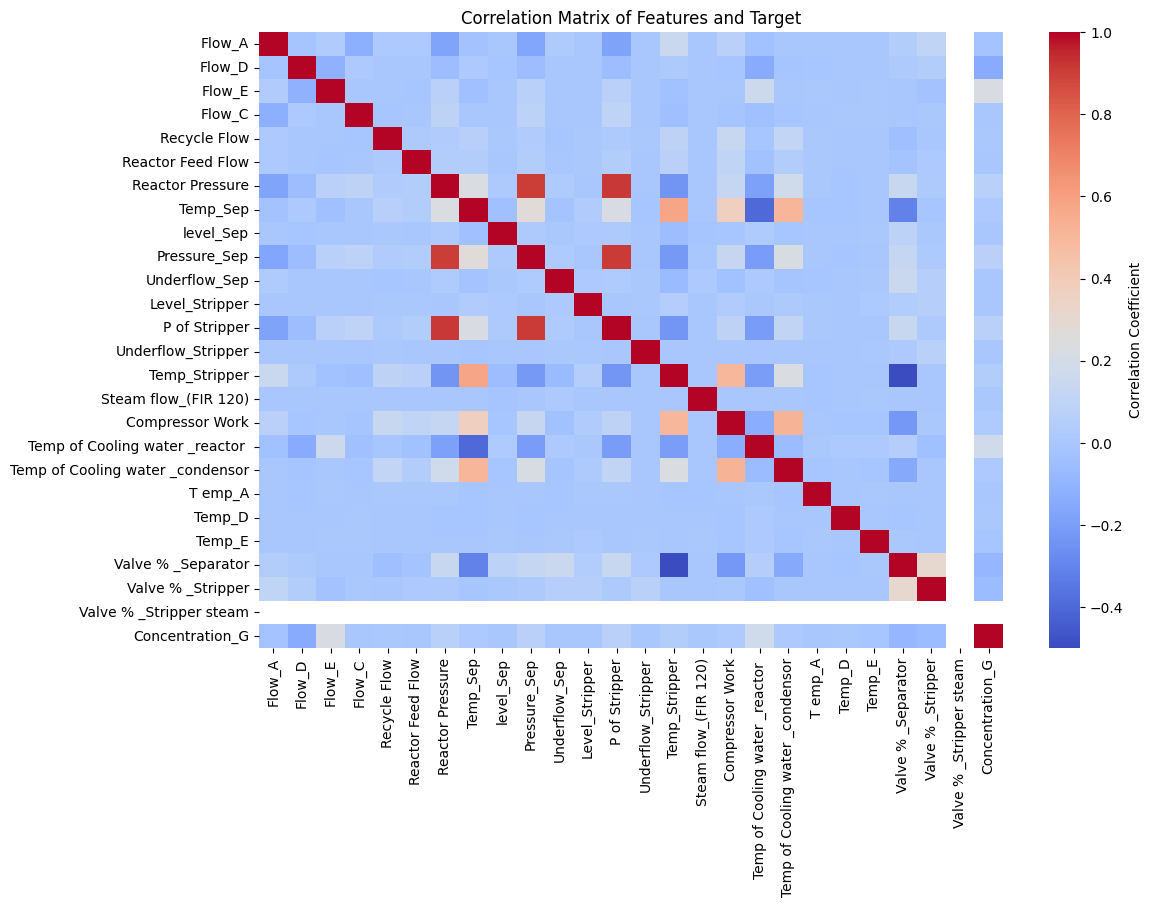

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert target variable to Series for correlation analysis
y_series = y.squeeze()  # If y is a DataFrame with a single column

# Combine features and target temporarily for correlation analysis
X_y_combined = pd.concat([X, y_series], axis=1)

# Calculate and plot the correlation matrix
correlation_matrix = X_y_combined.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})  # Turn off annotation

# Adjust axis labels
plt.title("Correlation Matrix of Features and Target")
plt.xticks(rotation=90)  # Vertical x-axis labels
plt.yticks(rotation=0)   # Horizontal y-axis labels
plt.show()


<Figure size 1500x1000 with 0 Axes>

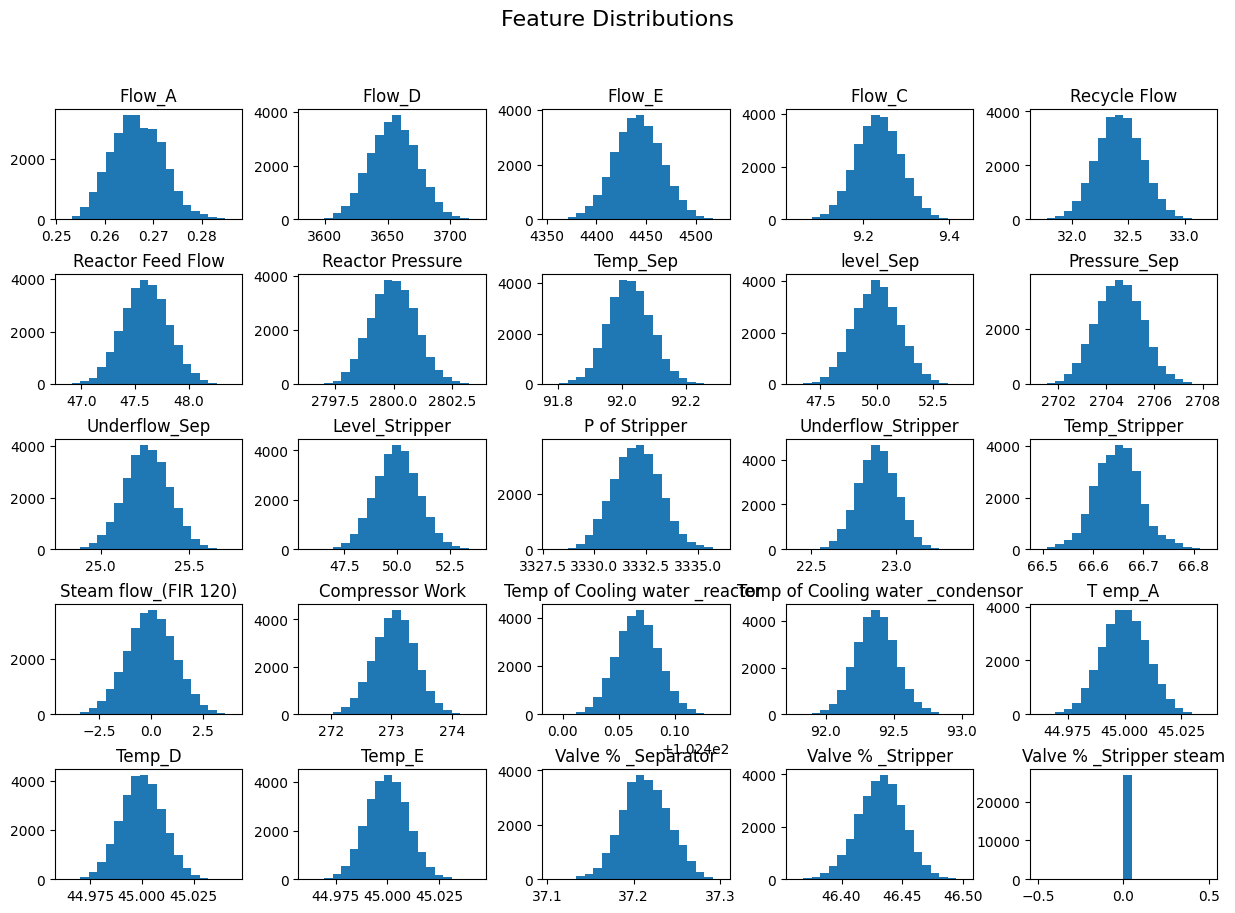

In [64]:

# Visualizing feature distributions
plt.figure(figsize=(15, 10))
X.hist(bins=20, figsize=(15, 10), grid=False)

# Add spacing between plots
plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing (increase hspace for more space)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


In [65]:
##Feature engineering
#Feature Transformation
# Example of applying log transformation to skewed features
X_transformed = X.copy()
skewed_features = X.columns[X.skew().abs() > 1]  # Identify highly skewed features

# Apply log transformation to reduce skewness (adjust this as needed)
for feature in skewed_features:
    X_transformed[feature] = np.log1p(X[feature])


In [66]:
#principle component analysis
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Check variance explained by each component
print("Explained Variance Ratios:", pca.explained_variance_ratio_)
print("Number of components:", pca.n_components_)


Explained Variance Ratios: [0.13454097 0.11186857 0.05711504 0.05315171 0.04369934 0.04279909
 0.04248807 0.04198473 0.0416603  0.04154912 0.0413971  0.04098242
 0.04053701 0.03996151 0.03960676 0.03727577 0.03688639 0.03246101
 0.02655572 0.02260511]
Number of components: 20


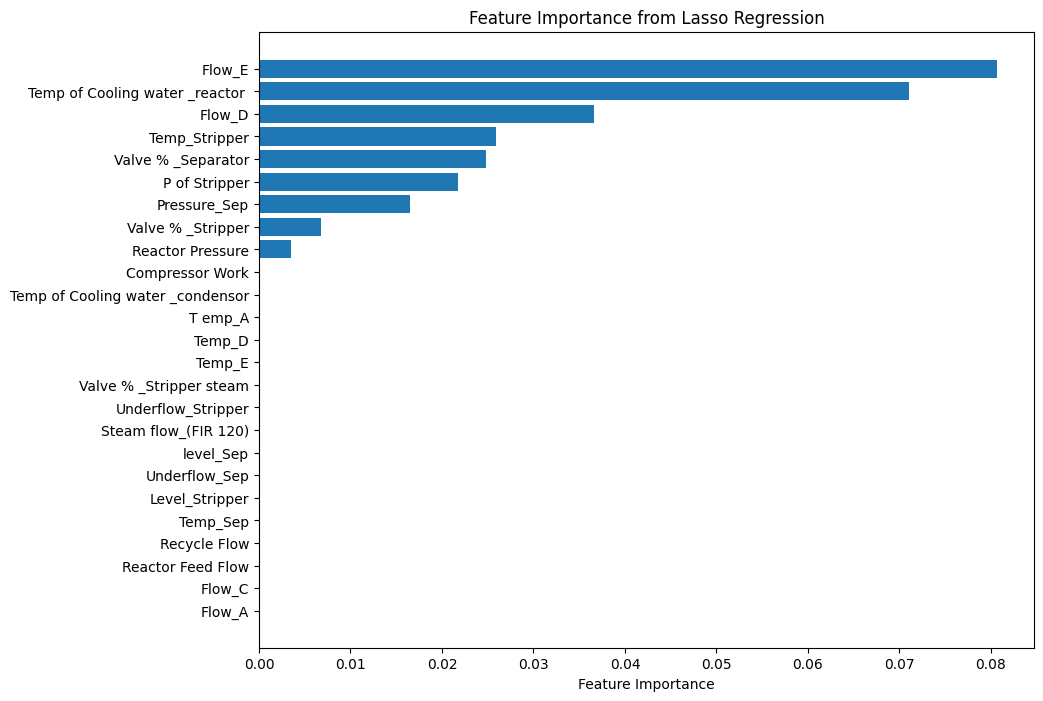

In [67]:
##Feature Importance with Tree based models
#Using Lasso for Feature Importance
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_scaled and y are already defined and contain the feature matrix and target variable

# Flatten y to ensure it’s a 1D array
y_flattened = y.values.ravel()  # Convert target variable to 1D array

# Fit Lasso Regression
lasso_model = Lasso(alpha=0.01, random_state=42)  # Adjust alpha for regularization strength
lasso_model.fit(X_scaled, y_flattened)

# Get feature importances (absolute values of coefficients)
lasso_importances = np.abs(lasso_model.coef_)
feature_names = X.columns
sorted_indices = np.argsort(lasso_importances)[::-1]  # Sort in descending order

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_indices)), lasso_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), feature_names[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Lasso Regression")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()



In [68]:
##Feature Selection
# Example: Selecting top 10 features based on feature importance
top_n = 10
top_features = feature_names[sorted_indices[:top_n]]
X_selected = X[top_features]  # Create a new feature matrix with selected features

# Print the names of the selected features
print("Top Features Selected:", top_features.tolist())


Top Features Selected: ['Flow_E', 'Temp of Cooling water _reactor ', 'Flow_D', 'Temp_Stripper', 'Valve % _Separator', 'P of Stripper', 'Pressure_Sep', 'Valve % _Stripper', 'Reactor Pressure', 'Compressor Work']


In [69]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model.__class__.__name__} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    return rmse, mae

# Load and prepare data (assume X_scaled and y are already defined)
# Splitting the data into 50% training, 20% testing, 30% validation
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Models to implement
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "Support Vector Regression (Linear)": SVR(kernel='linear'),
    "Support Vector Regression (RBF)": SVR(kernel='rbf'),
    "Support Vector Regression (Polynomial)": SVR(kernel='poly'),
    "Neural Network (MLP Regressor)": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "Polynomial Regression": Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("linear_model", LinearRegression())
    ])
}

# Evaluate each model using training and testing sets
results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    results[model_name] = evaluate_model(model, X_train, y_train, X_test, y_test)
    print("-" * 50)

# Display results summary
print("Model Performance Summary:")
for model_name, (rmse, mae) in results.items():
    print(f"{model_name}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")


# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model.__class__.__name__} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    return rmse, mae

# Load and prepare data (assume X_scaled and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Models to implement
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "Support Vector Regression (Linear)": SVR(kernel='linear'),
    "Support Vector Regression (RBF)": SVR(kernel='rbf'),
    "Support Vector Regression (Polynomial)": SVR(kernel='poly'),
    "Neural Network (MLP Regressor)": MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "Polynomial Regression": Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("linear_model", LinearRegression())
    ])
}

# Evaluate each model
results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    results[model_name] = evaluate_model(model, X_train, y_train, X_test, y_test)
    print("-" * 50)

# Display results summary
print("Model Performance Summary:")
for model_name, (rmse, mae) in results.items():
    print(f"{model_name}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")


Evaluating Linear Regression...
LinearRegression - RMSE: 0.4558, MAE: 0.3673
--------------------------------------------------
Evaluating Ridge Regression...
Ridge - RMSE: 0.4558, MAE: 0.3673
--------------------------------------------------
Evaluating Lasso Regression...
Lasso - RMSE: 0.4815, MAE: 0.3914
--------------------------------------------------
Evaluating Elastic Net...
ElasticNet - RMSE: 0.4815, MAE: 0.3914
--------------------------------------------------
Evaluating Support Vector Regression (Linear)...
SVR - RMSE: 0.4570, MAE: 0.3651
--------------------------------------------------
Evaluating Support Vector Regression (RBF)...
SVR - RMSE: 0.4609, MAE: 0.3654
--------------------------------------------------
Evaluating Support Vector Regression (Polynomial)...
SVR - RMSE: 0.4990, MAE: 0.3975
--------------------------------------------------
Evaluating Neural Network (MLP Regressor)...
MLPRegressor - RMSE: 0.5581, MAE: 0.4451
-----------------------------------------

In [70]:

### Hyperparameter Tuning with K-fold Cross Validation

# Import necessary libraries
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Suppress convergence warnings for MLP Regressor (optional)
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Function to perform K-fold cross-validation and evaluate models
def evaluate_model_with_kfold(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []
    mae_scores = []
    
    # Convert y to a NumPy array to ensure proper indexing
    y = np.array(y)
    
    # Loop through each fold
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        # Calculate RMSE and MAE for this fold
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        rmse_scores.append(rmse)
        mae_scores.append(mae)
    
    # Calculate average RMSE and MAE across all folds
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    
    print(f"{model.__class__.__name__} - Average RMSE: {avg_rmse:.4f}, Average MAE: {avg_mae:.4f}")
    
    return avg_rmse, avg_mae

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "Support Vector Regression (Linear)": SVR(kernel='linear'),
    "Support Vector Regression (RBF)": SVR(kernel='rbf'),
    "Support Vector Regression (Polynomial)": SVR(kernel='poly'),
    "Neural Network (MLP Regressor)": MLPRegressor(
        hidden_layer_sizes=(100,), 
        max_iter=1000,            # Increased number of iterations
        random_state=42, 
        solver='adam',           # Using the 'adam' optimizer
        learning_rate_init=0.001  # Set initial learning rate
    ),
    "Polynomial Regression": Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("linear_model", LinearRegression())
    ])
}

# Now, let's use K-fold cross-validation for each model

results_kfold = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name} with K-fold Cross-Validation...")
    results_kfold[model_name] = evaluate_model_with_kfold(model, X_val, y_val)  # Pass directly as arrays
    print("-" * 50)

# Display K-fold cross-validation results summary
print("K-fold Cross-Validation Results Summary:")
for model_name, (avg_rmse, avg_mae) in results_kfold.items():
    print(f"{model_name}: Average RMSE = {avg_rmse:.4f}, Average MAE = {avg_mae:.4f}")





Evaluating Linear Regression with K-fold Cross-Validation...
LinearRegression - Average RMSE: 0.4493, Average MAE: 0.3598
--------------------------------------------------
Evaluating Ridge Regression with K-fold Cross-Validation...
Ridge - Average RMSE: 0.4493, Average MAE: 0.3598
--------------------------------------------------
Evaluating Lasso Regression with K-fold Cross-Validation...
Lasso - Average RMSE: 0.4744, Average MAE: 0.3836
--------------------------------------------------
Evaluating Elastic Net with K-fold Cross-Validation...
ElasticNet - Average RMSE: 0.4744, Average MAE: 0.3836
--------------------------------------------------
Evaluating Support Vector Regression (Linear) with K-fold Cross-Validation...
SVR - Average RMSE: 0.4512, Average MAE: 0.3577
--------------------------------------------------
Evaluating Support Vector Regression (RBF) with K-fold Cross-Validation...
SVR - Average RMSE: 0.4555, Average MAE: 0.3602
--------------------------------------------

In [77]:
# Function to check for overfitting
def check_overfitting(model, X_train, y_train, X_test, y_test):
    # Fit the model on training data
    model.fit(X_train, y_train)
    
    # Predict on training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics for both
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Print the results
    print(f"{model.__class__.__name__} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"{model.__class__.__name__} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    
    # Check for overfitting: if train performance is much better than test performance
    if train_rmse < test_rmse and train_mae < test_mae:
        print(f"{model.__class__.__name__} may be overfitting.\n")
    else:
        print(f"{model.__class__.__name__} does not show signs of overfitting.\n")
    
# Evaluate each model on both training and testing data to check for overfitting
for model_name, model in models.items():
    print(f"Checking overfitting for {model_name}...")
    check_overfitting(model, X_train, y_train, X_test, y_test)
    print("-" * 50)


Checking overfitting for Ridge Regression...
Ridge - Train RMSE: 0.4508, Test RMSE: 0.4549
Ridge - Train MAE: 0.3619, Test MAE: 0.3655
Ridge may be overfitting.

--------------------------------------------------
Checking overfitting for Lasso Regression...
Lasso - Train RMSE: 0.4509, Test RMSE: 0.4549
Lasso - Train MAE: 0.3621, Test MAE: 0.3656
Lasso may be overfitting.

--------------------------------------------------
Checking overfitting for Elastic Net...
ElasticNet - Train RMSE: 0.4510, Test RMSE: 0.4549
ElasticNet - Train MAE: 0.3623, Test MAE: 0.3658
ElasticNet may be overfitting.

--------------------------------------------------
Checking overfitting for SVR (RBF)...
SVR - Train RMSE: 0.1773, Test RMSE: 0.4600
SVR - Train MAE: 0.1679, Test MAE: 0.3706
SVR may be overfitting.

--------------------------------------------------
Checking overfitting for SVR (Polynomial)...
SVR - Train RMSE: 0.4683, Test RMSE: 0.4826
SVR - Train MAE: 0.3769, Test MAE: 0.3896
SVR may be overfitti

In [79]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming X_train, X_test, y_train, y_test are already defined

# 1. Ridge, Lasso, and ElasticNet regularization tuning
params = {
    'alpha': [0.1, 1, 10, 100]
}

ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()

# GridSearchCV for Ridge
grid_ridge = GridSearchCV(ridge, params, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train, y_train)
print(f"Ridge best alpha: {grid_ridge.best_params_}")

# GridSearchCV for Lasso
grid_lasso = GridSearchCV(lasso, params, cv=5, scoring='neg_mean_squared_error')
grid_lasso.fit(X_train, y_train)
print(f"Lasso best alpha: {grid_lasso.best_params_}")

# GridSearchCV for ElasticNet
grid_elastic_net = GridSearchCV(elastic_net, params, cv=5, scoring='neg_mean_squared_error')
grid_elastic_net.fit(X_train, y_train)
print(f"ElasticNet best alpha: {grid_elastic_net.best_params_}")

# 2. SVR tuning (adjusting C and epsilon)
svr_rbf = SVR(kernel='rbf', C=1, epsilon=0.1)
svr_poly = SVR(kernel='poly', C=1, epsilon=0.1)

# 3. MLP Regressor tuning and early stopping
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, early_stopping=True, random_state=42)


# Function to evaluate model performance using cross-validation
def evaluate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-cv_scores.mean())
    return rmse

# 5. Evaluate models using cross-validation
print("Evaluating models using cross-validation...")

models = {
    "Ridge": grid_ridge.best_estimator_,
    "Lasso": grid_lasso.best_estimator_,
    "ElasticNet": grid_elastic_net.best_estimator_,
    "SVR (RBF)": svr_rbf,
    "SVR (Polynomial)": svr_poly,
    "MLP Regressor": mlp,
    
}

for name, model in models.items():
    rmse = evaluate_model(model, X_train, y_train)
    print(f"{name} - Cross-Validation RMSE: {rmse:.4f}")

# 6. Train and evaluate final model performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"\n{name} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"{name} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    
    # Check if overfitting is present based on RMSE difference
    if train_rmse < test_rmse:
        print(f"{name} may be overfitting.")
    else:
        print(f"{name} seems to be generalizing well.")


Ridge best alpha: {'alpha': 100}
Lasso best alpha: {'alpha': 0.1}
ElasticNet best alpha: {'alpha': 0.1}
Evaluating models using cross-validation...
Ridge - Cross-Validation RMSE: 0.4516
Lasso - Cross-Validation RMSE: 0.4748
ElasticNet - Cross-Validation RMSE: 0.4635
SVR (RBF) - Cross-Validation RMSE: 0.4512
SVR (Polynomial) - Cross-Validation RMSE: 0.4814
MLP Regressor - Cross-Validation RMSE: 0.4835

Ridge - Train RMSE: 0.4508, Test RMSE: 0.4549
Ridge - Train MAE: 0.3619, Test MAE: 0.3655
Ridge may be overfitting.

Lasso - Train RMSE: 0.4748, Test RMSE: 0.4817
Lasso - Train MAE: 0.3846, Test MAE: 0.3906
Lasso may be overfitting.

ElasticNet - Train RMSE: 0.4634, Test RMSE: 0.4693
ElasticNet - Train MAE: 0.3753, Test MAE: 0.3806
ElasticNet may be overfitting.

SVR (RBF) - Train RMSE: 0.3462, Test RMSE: 0.4496
SVR (RBF) - Train MAE: 0.2529, Test MAE: 0.3547
SVR (RBF) may be overfitting.

SVR (Polynomial) - Train RMSE: 0.4173, Test RMSE: 0.4748
SVR (Polynomial) - Train MAE: 0.3191, Test 

In [86]:
import pandas as pd

# Initialize a list to hold the summary data
summary_data = []

# 1. Collect the best parameters and RMSE scores for each model
for name, model in models.items():
    # For models with grid search, get the best parameters
    if 'GridSearchCV' in str(type(model)):
        best_params = model.best_params_
    else:
        best_params = 'N/A'
    
    # Evaluate model using cross-validation
    rmse_cv = evaluate_model(model, X_train, y_train)
    
    # Train and evaluate final model performance
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Add to summary list
    summary_data.append({
        'Model': name,
        'Best Parameters': best_params,
        'CV RMSE': rmse_cv,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
    })

# 2. Convert the summary data to a DataFrame for better visualization
summary_df = pd.DataFrame(summary_data)

# 3. Display the summary
print("Summary of Best Parameters and RMSE Scores:")
print(summary_df)



Summary of Best Parameters and RMSE Scores:
              Model Best Parameters  \
0  Ridge Regression             N/A   
1  Lasso Regression             N/A   
2       Elastic Net             N/A   
3         SVR (RBF)             N/A   
4  SVR (Polynomial)             N/A   
5     MLP Regressor             N/A   

                                      CV RMSE  Train RMSE  Test RMSE  \
0    (0.4508484650002185, 0.3619388810784227)    0.450848   0.454924   
1   (0.4508750599465372, 0.36206926863889766)    0.450875   0.454868   
2   (0.4509705874313177, 0.36231902963677215)    0.450971   0.454921   
3  (0.17727999807227504, 0.16787769640525654)    0.177280   0.459971   
4   (0.4682786934059154, 0.37691341962975755)    0.468279   0.482580   
5  (0.44079115379324685, 0.35471576383302517)    0.440791   0.467477   

   Train MAE  Test MAE  
0   0.361939  0.365546  
1   0.362069  0.365610  
2   0.362319  0.365845  
3   0.167878  0.370591  
4   0.376913  0.389629  
5   0.354716  0.374432  


In [88]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the function for model evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate RMSE and MAE for train and test data
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Return results as a dictionary
    return {
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae
    }

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Define models with their best hyperparameters (from GridSearchCV or previous tuning)
models = {
    "Ridge": grid_ridge.best_estimator_,
    "Lasso": grid_lasso.best_estimator_,
    "ElasticNet": grid_elastic_net.best_estimator_,
    "SVR (RBF)": svr_rbf,
    "SVR (Polynomial)": svr_poly,
    "MLP Regressor": mlp,
  
}

# Collect test results
results = []

# Evaluate all models
for name, model in models.items():
    model_results = evaluate_model(model, X_train, y_train, X_test, y_test)
    model_results['Model'] = name
    results.append(model_results)

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Print results in a DataFrame
print("Model Evaluation Results:")
print(results_df)


Model Evaluation Results:
   Train RMSE  Test RMSE  Train MAE  Test MAE             Model
0    0.450848   0.454924   0.361939  0.365546             Ridge
1    0.474771   0.481678   0.384595  0.390589             Lasso
2    0.463423   0.469286   0.375347  0.380596        ElasticNet
3    0.346181   0.449649   0.252864  0.354720         SVR (RBF)
4    0.417349   0.474841   0.319120  0.377942  SVR (Polynomial)
5    0.439154   0.464153   0.350973  0.371122     MLP Regressor


In [90]:
#Final Model Selection and Deployment Preparation
import joblib

# SVR(RBF) performs the best
joblib.dump(svr_rbf_best, "svr_rbf.pkl")
print("Best model saved as 'svr_rbf.pkl'.")


Best model saved as 'svr_rbf.pkl'.


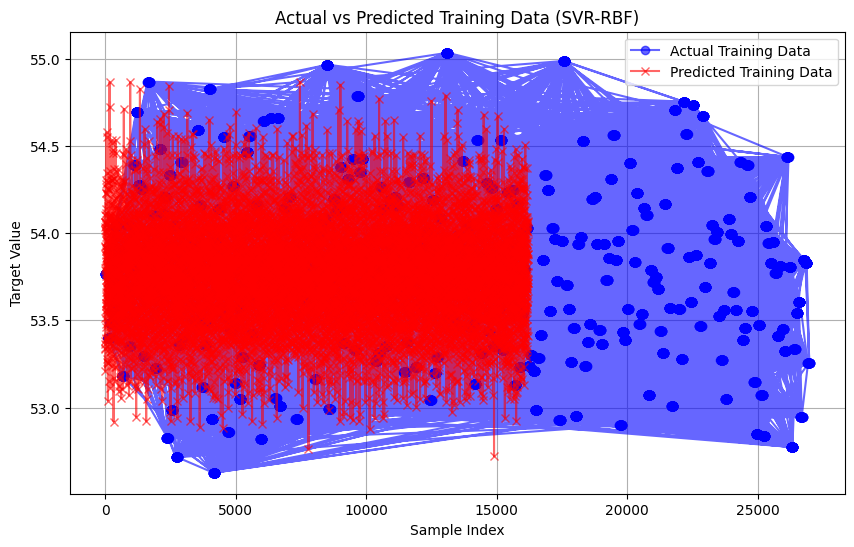

In [91]:
# Re-import necessary libraries
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

# Assuming 'X' and 'y' are already loaded and prepared in the previous steps

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Apply scaling to your feature matrix

# Step 2: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Step 3: Train the SVR-RBF model (use the best C and epsilon found from tuning)
svr_rbf_best = SVR(kernel='rbf', C=1, epsilon=0.1).fit(X_train, y_train)

# Step 4: Predict on the training data
y_train_pred = svr_rbf_best.predict(X_train)

# Step 5: Plot Actual vs Predicted values for the training data
plt.figure(figsize=(10, 6))
plt.plot(y_train, label="Actual Training Data", linestyle='-', marker='o', color='blue', alpha=0.6)
plt.plot(y_train_pred, label="Predicted Training Data", linestyle='-', marker='x', color='red', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Training Data (SVR-RBF)')
plt.legend()
plt.grid(True)
plt.show()


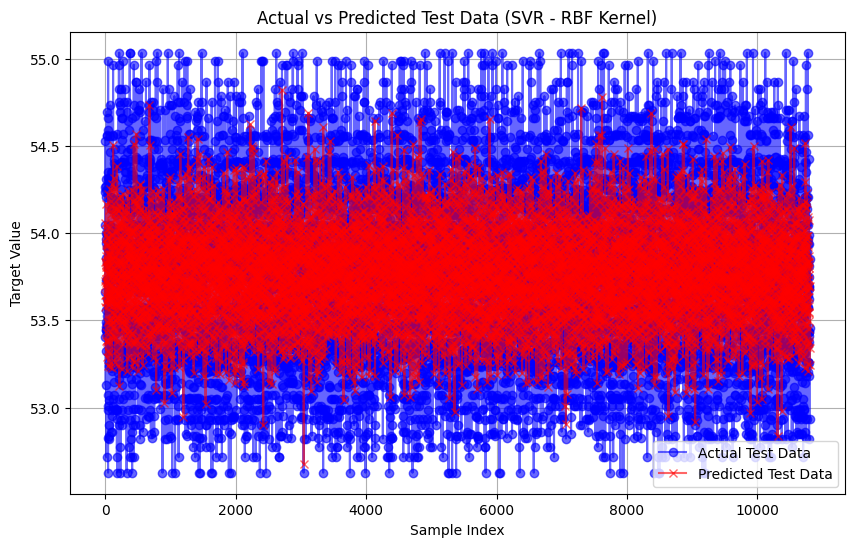

In [93]:
# Re-import necessary libraries for predictions and plotting
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming 'X' and 'y' are already defined and prepared in previous steps

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Apply scaling to your feature matrix

# Step 2: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Step 3: Train the SVR (RBF) model with best hyperparameters (assuming C=1 and epsilon=0.1 from previous tuning)
svr_best = SVR(kernel='rbf', C=1, epsilon=0.1).fit(X_train, y_train)

# Step 4: Predict on the test data
y_test_pred = svr_best.predict(X_test)

# Step 5: Plot Actual vs Predicted values for the test data
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual Test Data", linestyle='-', marker='o', color='blue', alpha=0.6)
plt.plot(y_test_pred, label="Predicted Test Data", linestyle='-', marker='x', color='red', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Test Data (SVR - RBF Kernel)')
plt.legend()
plt.grid(True)
plt.show()
